In [67]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import decorator
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

@decorator.decorator
def make_lnL(f, *args, **kwargs):
    return -1*np.log(f(*args, **kwargs))

def profile_it(f, **kwargs):
    from iminuit import Minuit
    dicty = {}
    for var, val in kwargs.items():
        dicty[var] = val
        dicty[f'fix_{var}'] = val
    m = Minuit(f, **dicty)
    return m.migrad()

Llabel = r'$\mathcal{L}$'
lnLlabel = r'$-\ln\mathcal{L}$'

from numpy.random import poisson as poisson_gen
from numpy.random import normal as gaussian_gen

def get_stats_classic(thing):
    length = len(thing)
    sorted_it = np.sort(thing)
    stats = []

    for frac in [0.025, 0.16, 0.84, 0.975, 0.5]:
        stats += [thing[int(frac*length)]]

    return stats[4], stats[0], stats[1], stats[2], stats[3]

def get_fraction_larger(thing, value):
    length = len(thing)
    if length == 0:
        raise ValueError
    integral = np.sum(thing >= value)
    return float(integral)/length

def get_fraction_smaller(thing, value):
    length = len(thing)
    if length == 0:
        raise ValueError
    integral = np.sum(thing < value)
    return float(integral)/length

# Limit setting exercise

Poisson distribution $P(k|\lambda)=\frac{\lambda^k}{k!}e^{-\lambda}$

In [2]:
from scipy.stats import poisson as poissonstats
def poisson(k, lmbda):
    return poissonstats.pmf(k, lmbda)

Gaussian distribution: $G(x|\mu\sigma)=\frac{1}{\sqrt(2\pi\sigma}e^{-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}}$

In [3]:
from scipy.stats import norm as gaussianstats
def gaussian(x, mu, sigma):
    return gaussianstats.pdf(x, mu,sigma)

# Experiment

In [34]:
true_control_region = 300
true_signal_region = 10 # No signal, background only number, SUSY is dead
susy_model = 4

In [35]:
observed_control_region = poisson_gen(true_control_region)
observed_signal_region = poisson_gen(true_signal_region)

In [36]:
background_estimate_from_mc = 200
relative_background_uncertainty = 0.2

In [37]:
def make_likelihood(CR_obs, SR_obs=None, SR_BKG_exp=None, constrained_mean=0):
    if SR_obs is None:
        def likelihood(a, nu):
            return -np.log(poisson(CR_obs,background_estimate_from_mc*(a + relative_background_uncertainty*nu))*gaussian(nu,constrained_mean,1))
    else:
        def likelihood(a, nu, alpha):
            return -np.log(poisson(CR_obs,background_estimate_from_mc*(a + relative_background_uncertainty*nu))*poisson(SR_obs,SR_BKG_exp*(a + relative_background_uncertainty*nu)+susy_model*alpha)*gaussian(nu,constrained_mean,1))
    return likelihood

### Actual expectation from MC

$N_{exp}^{MC}=N_0^{MC}\cdot(1+\nu\cdot30\%)\rightarrow N_0^{MC}\cdot(a+\nu\cdot30\%)$

In [1]:
n_obs = np.linspace(150,350,1000)
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(n_obs, poisson(np.floor(n_obs), background_estimate_from_mc), label='Model from MC')
plt.plot(n_obs, poisson(np.floor(n_obs), background_estimate_from_mc*(1.1+0.3*(-1))), label=r'MC $a=1.1$, $\nu=-1$')
plt.plot(n_obs, poisson(np.floor(n_obs), background_estimate_from_mc*(1.1+0.3*(0.5))), label=r'MC $a=1.1$, $\nu=0.5$')

ax.plot([observed_control_region, observed_control_region],[0,0.01])
ax.set_xlabel(r'$N_{Obs}$');
ax.set_ylabel(r'$PDF$');
a
ax.legend()

NameError: name 'np' is not defined

# Please help computer

$\mathcal{L}(a,\nu)=P(N_{obs}| N_0^{MC}\cdot(a+\nu\cdot30\%))$
and we know that $\nu$ follows a Gaussian distribution $G(\nu, \mu=0, \sigma=1)$
$\Rightarrow\mathcal{L}(a,\nu)=P(N_{obs}| N_0^{MC}\cdot(a+\nu\cdot30\%))\cdot G(\nu, \mu=0, \sigma=1)$
But we minimise $-\ln\mathcal{L}$


In [39]:
def likelihood(a, nu):
    return -np.log(poisson(observed_control_region,background_estimate_from_mc*(a + relative_background_uncertainty*nu))*gaussian(nu,0,1))

In [40]:
from iminuit import Minuit
m = Minuit(likelihood, a=1, nu=0, error_a=0.05, error_nu=0.05, errordef=0.5)
m.migrad();

FCN = 4.695022227534393 
 TOTAL NCALL = 48 
 NCALLS = 48 
 
 
 EDM = 3.7316410899193343e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,1.51513,0.217922,0,0,,,
2,nu,0.000536752,0.999084,0,0,,,


$\mathcal{L}(b)\approx G(b,b_{min},\sigma_b)=\frac{1}{\sqrt{2\pi \sigma}}e^{-\frac{1}{2}\frac{(b-b_{min})^2}{\sigma^2}}$

$-\ln\mathcal{L(b)}=\frac{1}{2}\frac{(b-b_{min})^2}{\sigma^2}+\ln(\sqrt{2\pi\sigma})$

$-\ln\mathcal{L}(b')-(-\ln\mathcal{L}(b_\min))=\frac{1}{2}\frac{(b-b_{min})^2}{\sigma^2}:=\frac{1}{2}\rightarrow \sigma=b'-b_{min}$

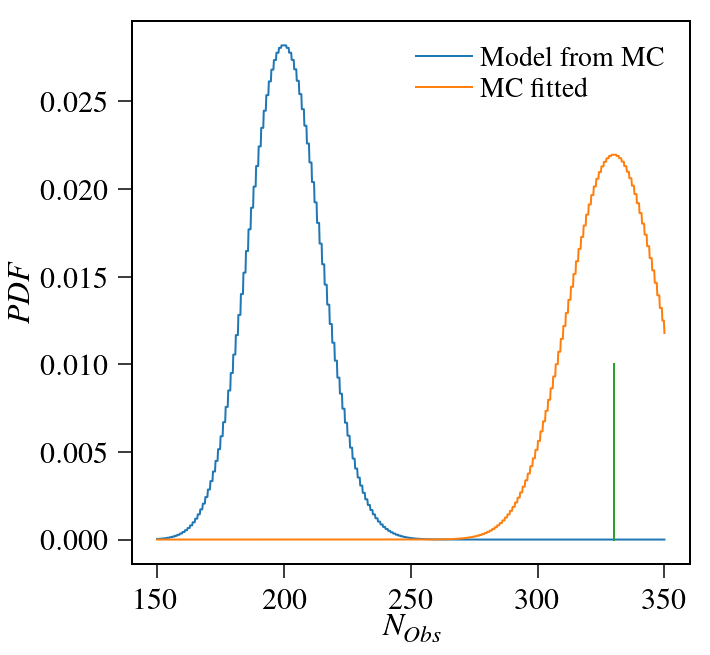

In [11]:
n_obs = np.linspace(150,350,1000)
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(n_obs, poisson(np.floor(n_obs), background_estimate_from_mc), label='Model from MC')
plt.plot(n_obs, poisson(np.floor(n_obs), background_estimate_from_mc*(m.values['a']+relative_background_uncertainty*(m.values['nu']))), label=r'MC fitted')

ax.plot([observed_control_region, observed_control_region],[0,0.01])
ax.set_xlabel(r'$N_{Obs}$');
ax.set_ylabel(r'$PDF$');
ax.legend()

# Please help computer

$\mathcal{L}(a,\nu,\alpha)=P(N^{CR}_{obs}| N^{CR}_{0}\cdot(a+\nu\cdot30\%))\cdot P(N^{SR}_{obs}| N^{SR}_{0}\cdot(a+\nu\cdot30\%) + N^{SR}_{SUSY}\cdot\alpha)\cdot G(\nu, \mu=0, \sigma=1)$

Imporant here: $\alpha$ is the parameter describing the signal strength which is free, but every sample has an $\alpha_{true}$ which we are ultimately interested in. We can generate toys for different $\alpha_{true}$ but we do not now its value in data (well, the one data we have generated here was created with $\alpha_{true}=0$, but we officially do not know this.

In [12]:
background_estimate_from_mc_signal = true_signal_region/m.values['a']

In [13]:
def likelihood2(a, nu, alpha):
    return -np.log(poisson(observed_control_region,background_estimate_from_mc*(a + relative_background_uncertainty*nu))*poisson(observed_signal_region,background_estimate_from_mc_signal*(a + relative_background_uncertainty*nu)+susy_model*alpha)*gaussian(nu,0,1))

In [14]:
msig = Minuit(likelihood2, a=1, nu=0, error_a=0.05, error_nu=0.05, alpha=0, error_alpha=0.1, limit_alpha=(0,4), errordef=0.5)

In [15]:
msig.migrad();
msig.print_matrix();

FCN = 7.016194578348505 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 2.9220653246255745e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,1.64993,0.219444,0,0,,,
2,nu,6.4528e-06,0.99903,0,0,,,
3,alpha,1.25039,0.933276,0,0,0.0,4.0,


+,a,nu,alpha
a,1.00,-0.91,-0.06
nu,-0.91,1.00,-0.00
alpha,-0.06,-0.00,1.00


# Now off to the limit setting

$\mathcal{L}(a,\nu,\alpha)$ is a function of $a$, $\nu$ and $\alpha$ and we have fitted all three values above.
A profile likelihood $\mathcal{L}(\alpha,\hat{\hat \nu},\hat{\hat a})$ is only a function of $\alpha$! For every $\alpha$, $\hat{\hat \nu}$ and $\hat{\hat a}$ are chosen such that they maximise the likelihood (by doing a fit).

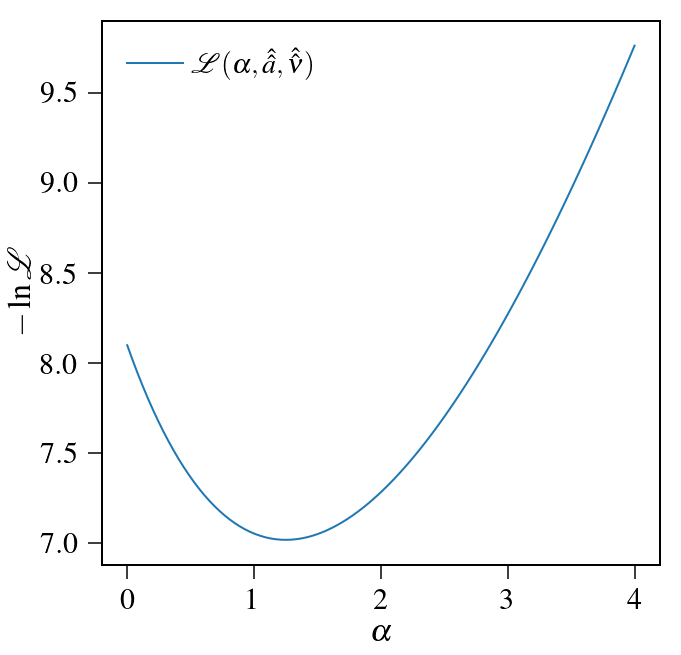

In [16]:
alpha_x, profile = msig.profile('alpha', bound=(0,4))

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(alpha_x, profile, label=r'$\mathcal{L}(\alpha, \hat{\hat a}, \hat{\hat \nu})$')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$-\ln\mathcal{L}$')
ax.legend()

# And now one last plot with the profile ratio $\rho$

Going to use $-\ln\rho$ instead of just $\rho$ as that is how we have defined the likelihoods above!
$-\ln\rho=-\ln\mathcal{L}(\alpha,\hat{\hat \nu},\hat{\hat a}) - (-\ln\mathcal{L}(\hat\alpha,\hat{\nu},\hat{a}))$

$\rho(\alpha)=\frac{\mathcal{L}(\alpha,\hat{\hat \nu},\hat{\hat a})}{\mathcal{L}(\hat\alpha,\hat{\nu},\hat{a})}$

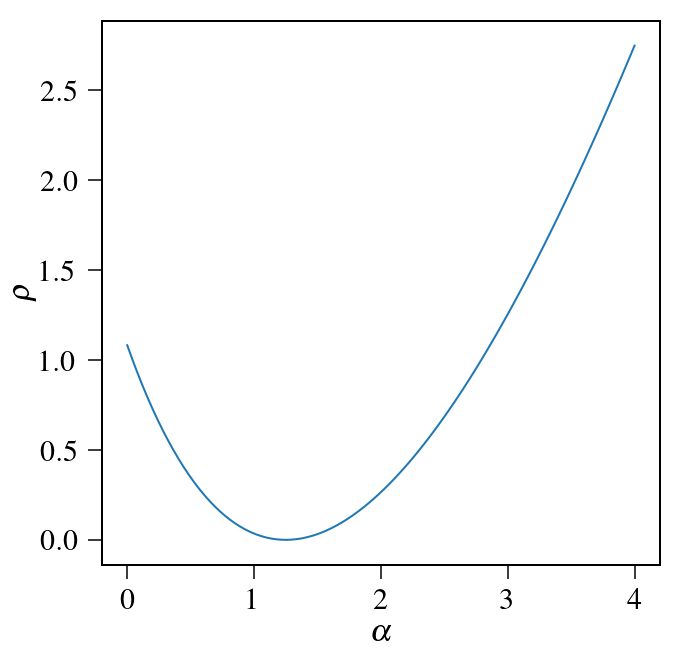

In [17]:
alpha_x, profile = msig.profile('alpha', bound=(0,4))
ln_ratio = profile - np.array(msig.fval)
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(alpha_x, ln_ratio)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho$');
#ax.legend()

# Ok cool, so what is $\rho$? Our test statistic, very sensitive!
* Every possible value of $\alpha_{true}$ is its own hypothesis. Two 'special' cases: $\alpha_{true}=0$ standard model only and $\alpha_{true}=1$ susy model like susy. We can tune the sensitivity of our test statistic $\rho(\alpha)$ by changing the parameter $\alpha$, where the best sensitivity is achieved for $\alpha=\alpha_{true}$
* We want to exclude those hypothesis that are incompatible with data. 
* We need to know: What range of profile likelihood ratio for any value $\alpha$ do we actually expect ASSUMING that the background only hypothesis is true?

# We could calculate those shapes using many assumptions, so instead : TOY PARTY

In [18]:
NTOYS=1000
NBINS=10

In [19]:
profiles = []
itoy=0
with tqdm(total=NTOYS) as pbar:
    while itoy<NTOYS:
        #That means we need to make new toy observed numbers and repeat the process many times!
        toy_observed_control_region = poisson_gen(true_control_region)
        toy_observed_signal_region = poisson_gen(true_signal_region)
        toy_constraint_mean = gaussian_gen(0,1)
        # Define the control region likelihood with the new yields:
        lnL_CR = make_likelihood(toy_observed_control_region, constrained_mean=toy_constraint_mean)
        m1 = Minuit(lnL_CR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, errordef=0.5, print_level=0)
        if not m1.migrad()[0]['is_valid']:
            continue   
        lnL_CRSR = make_likelihood(toy_observed_control_region, toy_observed_signal_region, true_signal_region/m1.values['a'], constrained_mean=toy_constraint_mean)
        m2 = Minuit(lnL_CRSR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, alpha=0, error_alpha=0.1, limit_alpha=(0,4),limit_a=(1.,3.),limit_nu=(-5,5), errordef=0.5, print_level=0)
        if not m2.migrad()[0]['is_valid']:
            continue     
        alpha_x, tmp = m2.profile('alpha', bound=(0,4), bins=NBINS)
        profiles += [tmp-np.array(m2.fval)]
        itoy = itoy + 1
        pbar.update(1)


100%|██████████| 1000/1000 [00:26<00:00, 38.11it/s]


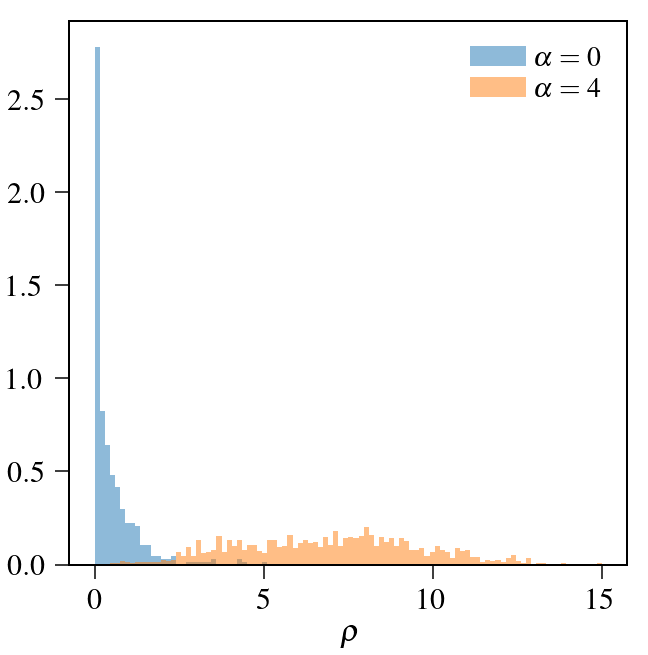

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(np.transpose(profiles)[0], bins=100, label=r'$\alpha=0$', alpha=0.5, range=(0,15), normed=True)
ax.hist(np.transpose(profiles)[-1], bins=100, label=r'$\alpha=4$',alpha=0.5, range=(0,15), normed=True)
ax.set_xlabel(r'$\rho$')
ax.legend()

(0, 4)

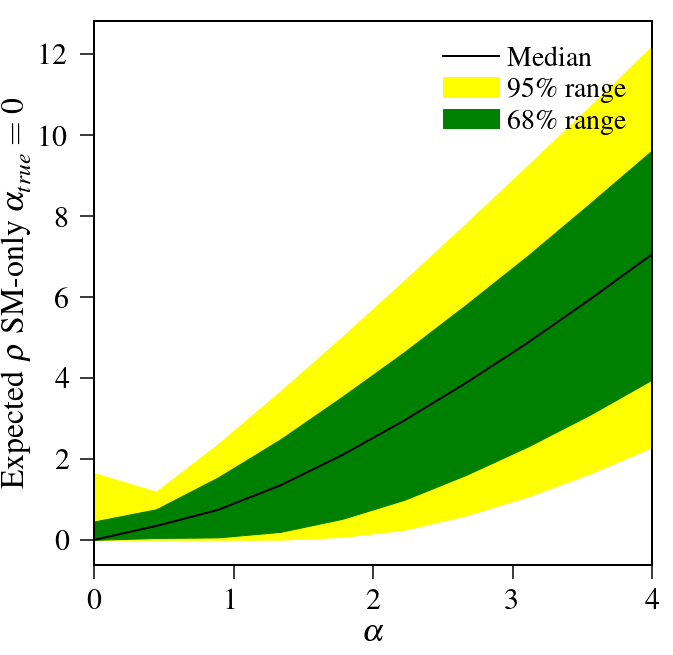

In [21]:
sorted_profiles = np.sort(np.transpose(profiles), axis=1)
median, LOWER, lower, higher, HIGHER = zip(*list([get_stats_classic(i[~np.isnan(i)]) for i in sorted_profiles]))
fig, ax = plt.subplots(figsize=(10,10))
ax.fill_between(alpha_x, LOWER, HIGHER, label=r'95\% range', color='yellow')
ax.fill_between(alpha_x, lower, higher, label=r'68\% range', color='green')
ax.plot(alpha_x, median, label=r'Median', color='black')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'Expected $\rho$ SM-only $\alpha_{true}=0$')
ax.legend()
ax.set_xlim((0,4))

# And now for expected SUSY 

In [22]:
SUSYprofiles = []
for _ in tqdm(range(NTOYS)):
    #That means we need to make new toy observed numbers and repeat the process many times!
    toy_observed_control_region = poisson_gen(true_control_region)
    toy_observed_signal_region = poisson_gen(true_signal_region + susy_model)
    toy_constraint_mean = gaussian_gen(0,1)

    # Define the control region likelihood with the new yields:
    lnL_CR = make_likelihood(toy_observed_control_region)
    m1 = Minuit(lnL_CR, a=1, nu=0, error_a=0.05, error_nu=0.05, errordef=0.5, print_level=0)
    bla = m1.migrad();
    lnL_CRSR = make_likelihood(toy_observed_control_region, toy_observed_signal_region, true_signal_region/m1.values['a'])
    m2 = Minuit(lnL_CRSR, a=1, nu=0, error_a=0.05, error_nu=0.05, alpha=1, error_alpha=0.1, limit_alpha=(0,4), limit_a=(1.,3.),limit_nu=(-5,5), errordef=0.5, print_level=0)
    bla = m2.migrad();
    alpha_x, tmp = m2.profile('alpha', bound=(0,4), bins=NBINS)
    SUSYprofiles += [tmp-np.array(m2.fval)]


100%|██████████| 1000/1000 [00:24<00:00, 40.61it/s]


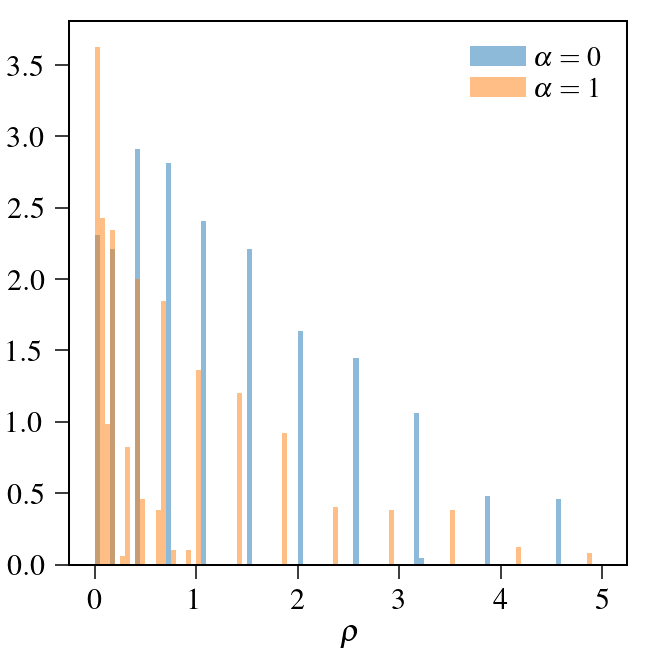

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(np.transpose(SUSYprofiles)[0], bins=100, label=r'$\alpha=0$', alpha=0.5, range=(0,5), normed=True)
ax.hist(np.transpose(SUSYprofiles)[1], bins=100, label=r'$\alpha=1$',alpha=0.5, range=(0,5), normed=True)
ax.set_xlabel(r'$\rho$')
ax.legend()

(0, 4)

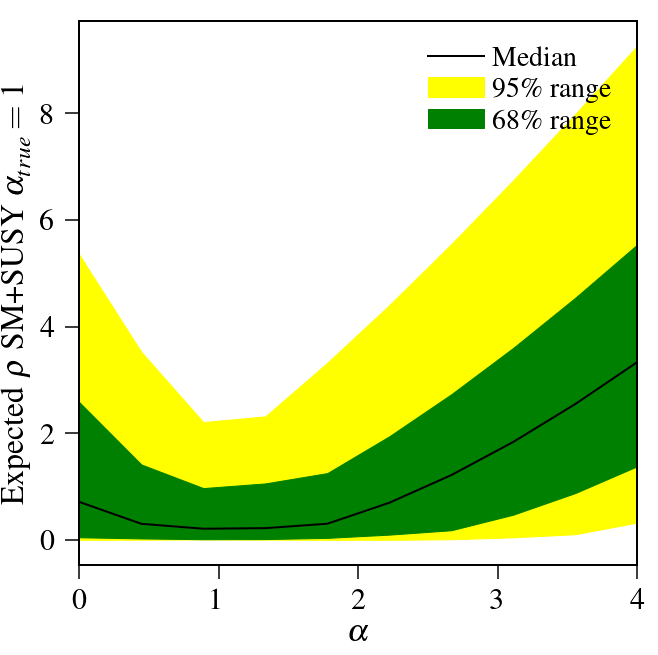

In [24]:
sorted_SUSYprofiles = np.sort(np.transpose(SUSYprofiles), axis=1)
median, LOWER, lower, higher, HIGHER = zip(*list([get_stats_classic(i[~np.isnan(i)]) for i in sorted_SUSYprofiles]))
fig, ax = plt.subplots(figsize=(10,10))
ax.fill_between(alpha_x, LOWER, HIGHER, label=r'95\% range', color='yellow')
ax.fill_between(alpha_x, lower, higher, label=r'68\% range', color='green')
ax.plot(alpha_x, median, label=r'Median', color='black')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'Expected $\rho$ SM+SUSY $\alpha_{true}=1$')
ax.legend()
ax.set_xlim((0,4))

# Okay, now we have done this, lets actually make it for 10 $\alpha_{true}$ steps from 0 to 4

In [25]:
ForCLSprofiles = {}
ForCLSprofiles[0] = profiles
for imu in alpha_x[1:]: # already have it for mu=zero
    itoy=0 # Make a counter here that only increments when the fits have converged
    ForCLSprofiles[imu] = []
    with tqdm(total=NTOYS) as pbar:
        while itoy<NTOYS:
            #That means we need to make new toy observed numbers and repeat the process many times!
            toy_observed_control_region = poisson_gen(true_control_region)
            toy_observed_signal_region = poisson_gen(true_signal_region + imu*susy_model) #important here to scale it now
            toy_constraint_mean = gaussian_gen(0,1)

            # Define the control region likelihood with the new yields:
            lnL_CR = make_likelihood(toy_observed_control_region, constrained_mean=toy_constraint_mean)
            m1 = Minuit(lnL_CR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, errordef=0.5, print_level=0)
            if not m1.migrad()[0]['is_valid']:
                continue
            lnL_CRSR = make_likelihood(toy_observed_control_region, toy_observed_signal_region, true_signal_region/m1.values['a'], constrained_mean=toy_constraint_mean)
            m2 = Minuit(lnL_CRSR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, alpha=imu, error_alpha=0.05, limit_alpha=(0,4),limit_a=(1.,3.),limit_nu=(-5,5), errordef=0.5, print_level=0)
            if not m2.migrad()[0]['is_valid']:
                continue
            alpha_x, tmp = m2.profile('alpha', bound=(0,4), bins=NBINS)
            ForCLSprofiles[imu] += [tmp-np.array(m2.fval)]
            pbar.update(1)
            itoy = itoy + 1

 55%|█████▍    | 546/1000 [00:13<00:11, 40.60it/s]/home/dmuller/miniconda3/envs/old/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/dmuller/miniconda3/envs/old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        a = +nan
       nu = +nan
    alpha = +nan

/home/dmuller/miniconda3/envs/old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        a = -nan
       nu = -nan
    alpha = -nan

100%|██████████| 1000/1000 [00:25<00:00, 38.67it/s]


In [26]:
muProfiles = []
for i, a in enumerate(alpha_x):
    muProfiles += [np.transpose(ForCLSprofiles[a])[i]]
muProfiles = np.transpose(muProfiles)

# Now let's set a limit on $\alpha_{true}$
We will use $CL_s$ defined as: $CL_s=\frac{p_{sig}}{1-p_{bkg}}$
To be most sensitive, for scan point in $\alpha_{true}$ (we only have 10 because we did 10 toys with different $\alpha_{true})$, we look at the distribution of the test statistic $\rho(\alpha=\alpha_{true})$ as this choice of $\alpha$ will give the largest sensitivity.
We then create an additional toys for $\alpha_{true}=0$ and compute the $CL_s$ value for each of these toys at each of the scan points. First, we compute the observed value of the test statistic in each toy, $\rho_{obs}(\alpha=\alpha_{true})$, with $\alpha$ chosen to be most at the respective scan point. The value of $p_{sig}$ is then obtained by integrating the expected distribution of $\rho(\alpha=\alpha_{true})$ obtained from the set of toys for that specific $\alpha_{true}$. The value of $p_{bkg}$ is then obtained by integrating the expected distribution of $\rho(\alpha=\alpha_{true})$ obtained from the set of toys for $\alpha_{true}=0$. 

We then get the expected limit and its statistical variation by computing the average $CL_s$ value and spread at each scan point in $\alpha_{true}$

In [59]:
Expected_cls = []
itoy=0
with tqdm(total=NTOYS) as pbar:
    while itoy<NTOYS:
        # Try to make some expected exclusion plots
        toy_observed_control_region = poisson_gen(true_control_region)
        toy_observed_signal_region = poisson_gen(true_signal_region)
        toy_constraint_mean = 0
        # Define the control region likelihood with the new yields:
        lnL_CR = make_likelihood(toy_observed_control_region, constrained_mean=toy_constraint_mean)
        m1 = Minuit(lnL_CR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, errordef=0.5, print_level=0)
        if not m1.migrad()[0]['is_valid']:
            continue
        lnL_CRSR = make_likelihood(toy_observed_control_region, toy_observed_signal_region, true_signal_region/m1.values['a'], constrained_mean=toy_constraint_mean)
        m2 = Minuit(lnL_CRSR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, alpha=0, error_alpha=0.1, limit_alpha=(0,4),limit_a=(1.,3.),limit_nu=(-5,5), errordef=0.5, print_level=0)
        if not m2.migrad()[0]['is_valid']:
            continue
        alpha_x, tmp = m2.profile('alpha', bound=(0,4), bins=NBINS)
        tmp -= np.array(m2.fval)
        bkg_pval = np.array([get_fraction_smaller(k,x) for k, x in zip(np.transpose(profiles), tmp)])
        sig_pval = np.array([get_fraction_larger(k,x) for k, x in zip(np.transpose(muProfiles), tmp)])
        Expected_cls += [sig_pval/(1-bkg_pval)]
        itoy += 1
        pbar.update(1)

 73%|███████▎  | 728/1000 [00:19<00:08, 33.98it/s]/home/dmuller/miniconda3/envs/old/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/dmuller/miniconda3/envs/old/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 1000/1000 [00:26<00:00, 37.07it/s]


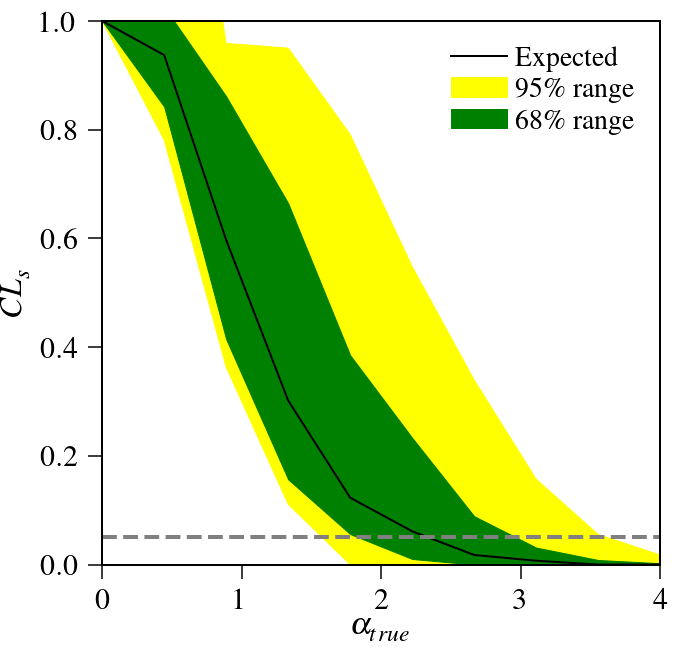

In [65]:
sorted_exp_cls = np.sort(np.transpose(Expected_cls), axis=1)
median, LOWER, lower, higher, HIGHER = zip(*list([get_stats_classic(i[~np.isnan(i)]) for i in sorted_exp_cls]))
fig, ax = plt.subplots(figsize=(10,10))
ax.fill_between(alpha_x, LOWER, HIGHER, label=r'95\% range', color='yellow')
ax.fill_between(alpha_x, lower, higher, label=r'68\% range', color='green')
ax.plot(alpha_x, median, label=r'Expected', color='black')
ax.plot([0,4],[0.05,0.05], color='grey', linewidth=4, linestyle='--')
ax.set_xlabel(r'$\alpha_{true}$')
ax.set_ylabel(r'$CL_s$')
ax.legend()
ax.set_xlim((0,4));
ax.set_ylim((0,1));

# Now do the same calculation using the observed numbers and draw the limit
Lastly, we do the same thing as described above for the one data sample we have generated at the very beginning to get an observed $CL_s$ value at each scan point in $\alpha_{true}$

In [62]:
# Define the control region likelihood with the new yields:
lnL_CR = make_likelihood(observed_control_region)
m1 = Minuit(lnL_CR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, errordef=0.5, print_level=0)
m1.migrad()
lnL_CRSR = make_likelihood(observed_control_region, observed_signal_region, true_signal_region/m1.values['a'])
m2 = Minuit(lnL_CRSR, a=1, nu=toy_constraint_mean, error_a=0.05, error_nu=0.05, alpha=0, error_alpha=0.1, limit_alpha=(0,4),limit_a=(1.,3.),limit_nu=(-5,5), errordef=0.5, print_level=0)
m2.migrad()
alpha_x, tmp = m2.profile('alpha', bound=(0,4), bins=NBINS)
tmp -= np.array(m2.fval)
bkg_pval = np.array([get_fraction_smaller(k,x) for k, x in zip(np.transpose(profiles), tmp)])
sig_pval = np.array([get_fraction_larger(k,x) for k, x in zip(np.transpose(muProfiles), tmp)])
ObservedCls = sig_pval/(1-bkg_pval)

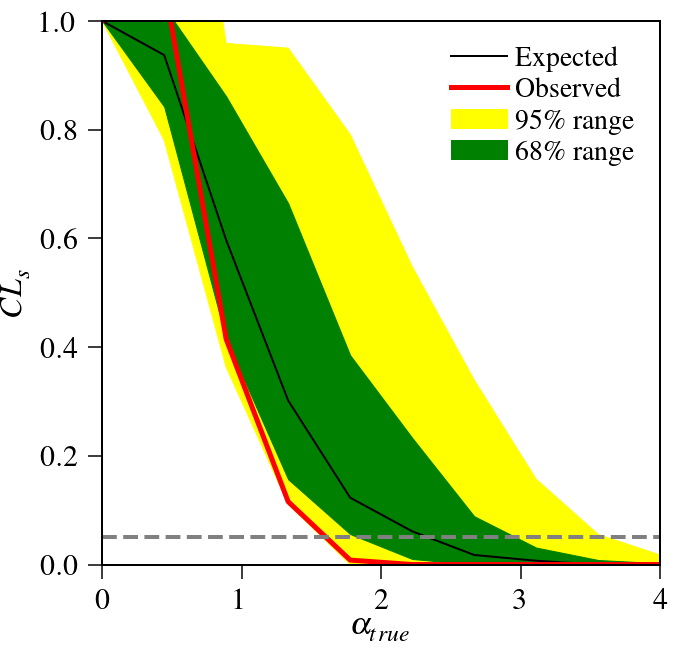

In [66]:
sorted_exp_cls = np.sort(np.transpose(Expected_cls), axis=1)
median, LOWER, lower, higher, HIGHER = zip(*list([get_stats_classic(i[~np.isnan(i)]) for i in sorted_exp_cls]))
fig, ax = plt.subplots(figsize=(10,10))
ax.fill_between(alpha_x, LOWER, HIGHER, label=r'95\% range', color='yellow')
ax.fill_between(alpha_x, lower, higher, label=r'68\% range', color='green')
ax.plot(alpha_x, median, label=r'Expected', color='black')
ax.plot(alpha_x, ObservedCls, label=r'Observed', color='red', linewidth=5)
ax.plot([0,4],[0.05,0.05], color='grey', linewidth=4, linestyle='--')
ax.set_xlabel(r'$\alpha_{true}$')
ax.set_ylabel(r'$CL_s$')
ax.legend()
ax.set_xlim((0,4));
ax.set_ylim((0,1));
fig.savefig('LimitPlot.pdf')

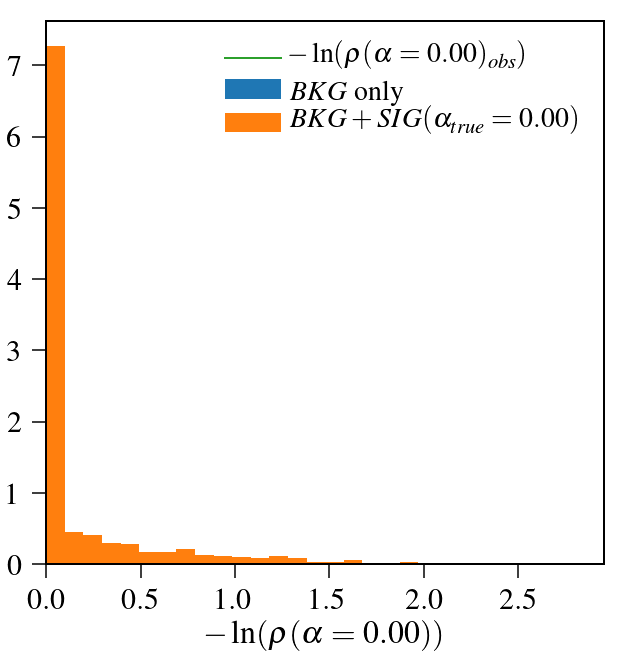

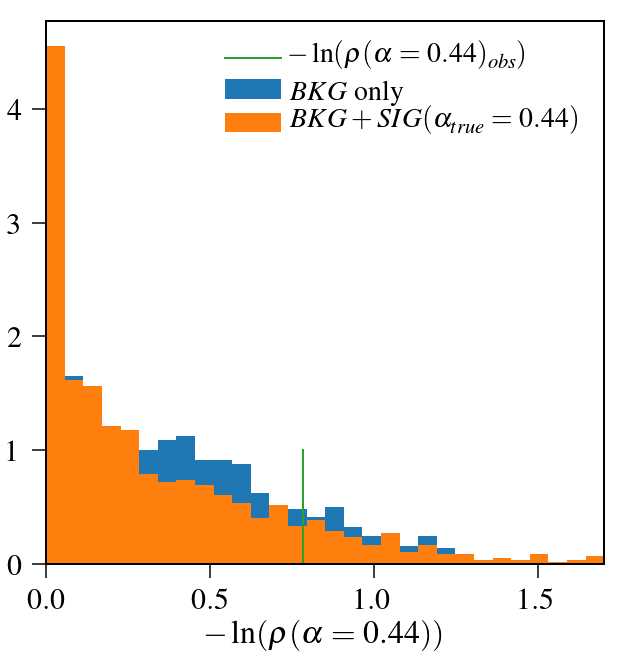

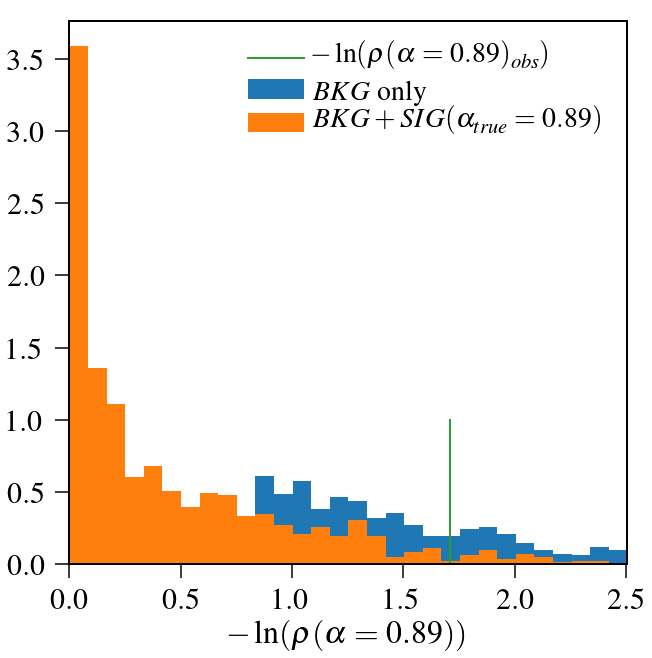

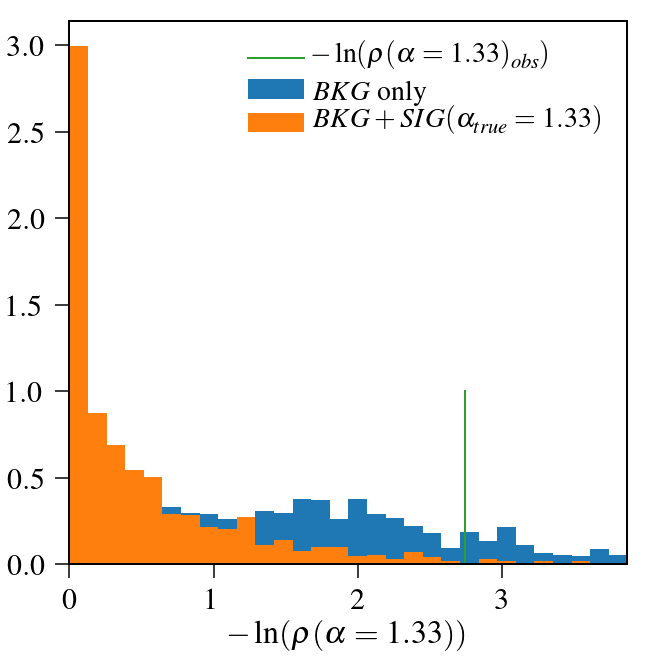

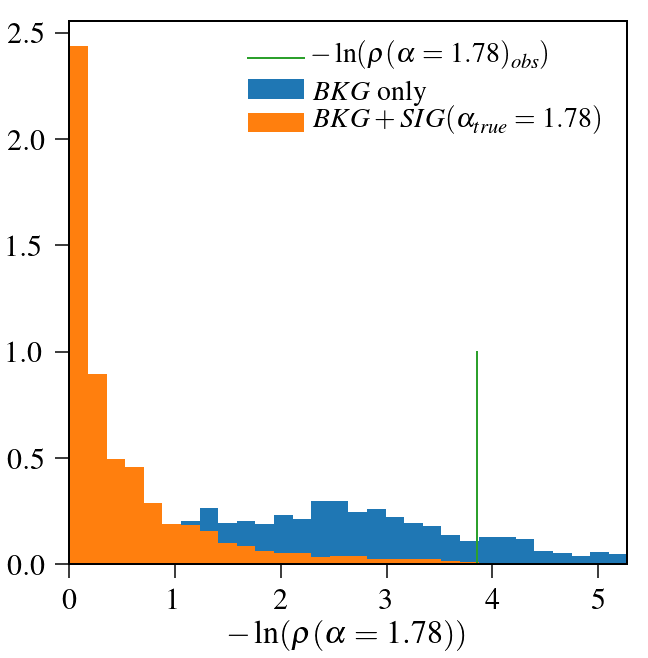

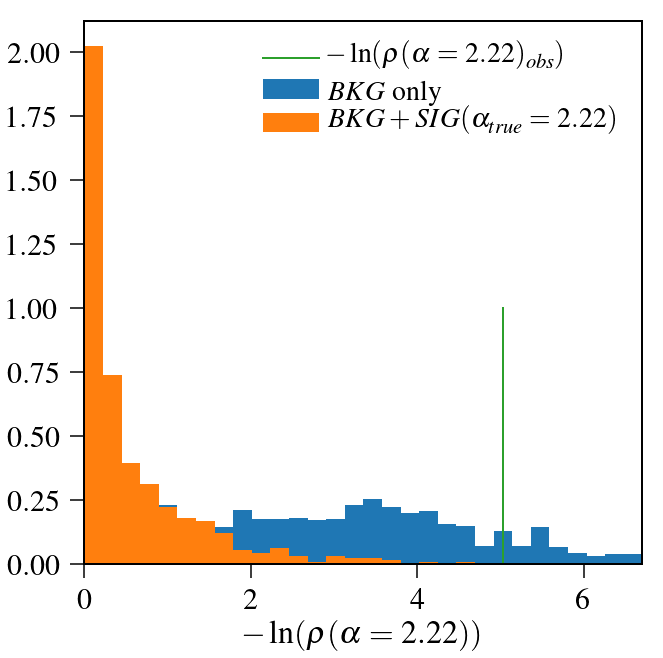

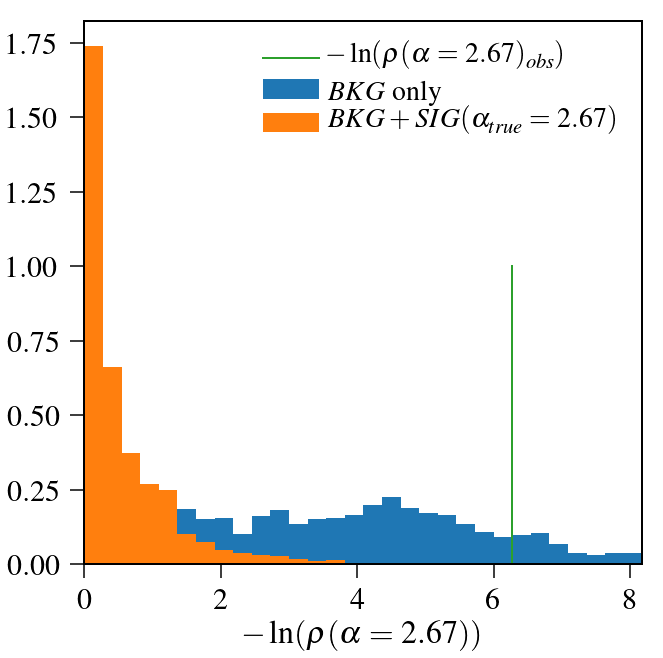

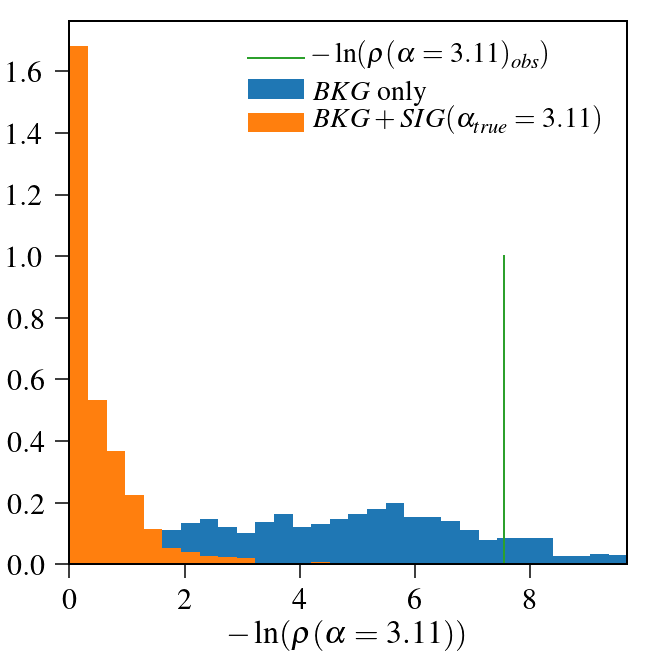

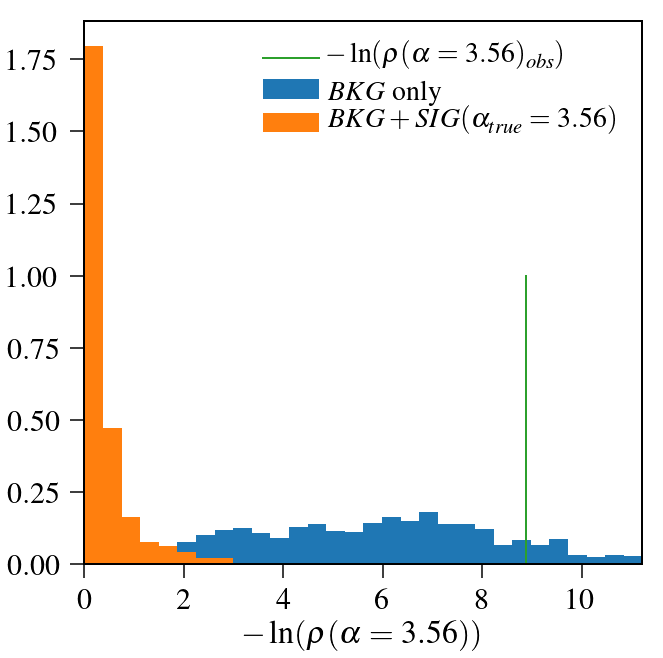

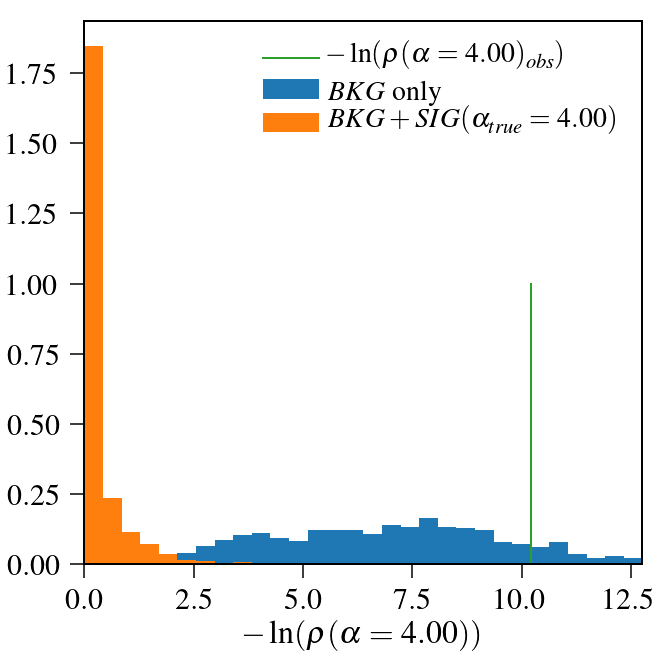

In [69]:
pdf = PdfPages('sig_bkg_hypothesis.pdf')
for alp, bkg, sig, tobs in zip(alpha_x, np.transpose(profiles), np.transpose(muProfiles), tmp):
    fig, ax = plt.subplots(figsize=(10,10))
    upper_boundary = np.sort(bkg)[int(0.99*len(bkg))]
    lower_boundary = np.sort(sig)[int(0.01*len(sig))]

    ax.hist(bkg, range=(lower_boundary,upper_boundary), bins=30, label=r'$BKG$ only', normed=True)
    ax.hist(sig, range=(lower_boundary,upper_boundary), bins=30, label=r'$BKG + SIG(\alpha_{{true}}={:.2f})$'.format(alp), normed=True)
    ax.plot([tobs, tobs], [0,1], label=r'$-\ln(\rho(\alpha={:.2f})_{{obs}})$'.format(alp))
    ax.set_xlim((lower_boundary,upper_boundary))
    ax.legend()
    ax.set_xlabel(r'$-\ln(\rho(\alpha={:.2f}))$'.format(alp))
    pdf.savefig(fig)
pdf.close()